In [4]:
import pandas as pd

# Import data from a XLSX file
data = pd.read_excel('online_retail_II.xlsx')

# Display the first few rows of the dataframe
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [14]:
# Check for length of the data
len(data)

525461

In [13]:
# Check for missing values in each column
data.isnull().sum().sort_values(ascending=False)

Customer ID    107927
Description      2928
Invoice             0
StockCode           0
Quantity            0
InvoiceDate         0
Price               0
Country             0
dtype: int64

In [15]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,525461.0,10.337667,-9600.0,1.0,3.0,10.0,19152.0,107.42411
InvoiceDate,525461,2010-06-28 11:37:36.845017856,2009-12-01 07:45:00,2010-03-21 12:20:00,2010-07-06 09:51:00,2010-10-15 12:45:00,2010-12-09 20:01:00,NaN
Price,525461.0,4.688834,-53594.36,1.25,2.1,4.21,25111.09,146.126914
Customer ID,417534.0,15360.645478,12346.0,13983.0,15311.0,16799.0,18287.0,1680.811316


In [16]:
# 1. Drop rows with missing Customer ID
data.dropna(subset = ['Customer ID'], inplace = True)

# 2. Remove negative or zero Quantity and Price
data = data[(data['Quantity'] > 0) & (data['Price'] > 0)]

# Lets see the cleaned data
print('Rows:', data.shape[0])
data.describe().T

Rows: 407664


,count,mean,min,25%,50%,75%,max,std
Quantity,407664.0,13.585585,1.0,2.0,5.0,12.0,19152.0,96.840747
InvoiceDate,407664,2010-07-01 10:15:11.871688192,2009-12-01 07:45:00,2010-03-26 14:01:00,2010-07-09 15:47:00,2010-10-14 17:09:00,2010-12-09 20:01:00,NaN
Price,407664.0,3.294438,0.001,1.25,1.95,3.75,10953.5,34.757965
Customer ID,407664.0,15368.592598,12346.0,13997.0,15321.0,16812.0,18287.0,1679.762138


In [18]:
import datetime as dt

# 1. Total Price of each row
data['TotalPrice'] = data['Quantity'] * data['Price']

# 2. Set reference date
# Find the max date in the dataset
last_date = data['InvoiceDate'].max()

# Set reference date as two day after the last date
reference_date = last_date + dt.timedelta(days = 2)

print('Final Date in Dataset:', last_date)
print('Reference Date:', reference_date)
print('----------------------------')
data.head()

Final Date in Dataset: 2010-12-09 20:01:00
Reference Date: 2010-12-11 20:01:00
----------------------------


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [19]:
# Customer Level Data
rfm = data.groupby('Customer ID').agg({
    'InvoiceDate': lambda date: (reference_date - date.max()).days,   # Recency
    'Invoice': lambda num: num.nunique(),                             # Frequency
    'TotalPrice': lambda price: price.sum()                           # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Lets select only Monetary > 0
rfm = rfm[rfm['Monetary'] > 0]

# Lets see the rfm data
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,166,11,372.86
12347.0,4,2,1323.32
12348.0,75,1,222.16
12349.0,44,3,2671.14
12351.0,12,1,300.93


In [20]:
# 1. Recency Score (5 is the most recent)
rfm['RecencyScore'] = pd.qcut(rfm['Recency'], 5, labels = [5, 4, 3, 2, 1])

# 2. Frequency Score (5 is the most frequent)
rfm['FrequencyScore'] = pd.qcut(rfm['Frequency'].rank(method = 'first'), 5, labels = [1, 2, 3, 4, 5])

# 3. Monetary Score (5 is the highest monetary)
rfm['MonetaryScore'] = pd.qcut(rfm['Monetary'], 5, labels = [1, 2, 3, 4, 5])

# Combine Recency and Frequency scores
rfm['RFM_Score'] = (
    rfm['RecencyScore'].astype(str) +
    rfm['FrequencyScore'].astype(str)
)

# Display the RFM table
rfm.head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score
Customer ID,,,,,,,
12346.0,166,11,372.86,2,5,2,25
12347.0,4,2,1323.32,5,2,4,52
12348.0,75,1,222.16,2,1,1,21
12349.0,44,3,2671.14,3,3,5,33
12351.0,12,1,300.93,5,1,2,51


In [21]:
# RFM Segmentation Map
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At_Risk',
    r'[1-2]5': 'Cant_Lose',
    r'3[1-2]': 'About_to_Sleep',
    r'33': 'Need_Attention',
    r'[3-4][4-5]': 'Loyal_Customers',
    r'41': 'Promising',
    r'51': 'New_Customers',
    r'[4-5][2-3]': 'Potential_Loyalists',
    r'5[4-5]': 'Champions'
}

# Create a new column 'Segment' based on the RFM_Score
rfm['Segment'] = rfm['RFM_Score'].replace(seg_map, regex = True)

# Display the count of customers in each segment
rfm['Segment'].value_counts()

Segment
Hibernating            1015
Loyal_Customers         742
Champions               663
At_Risk                 611
Potential_Loyalists     517
About_to_Sleep          343
Need_Attention          207
Promising                87
Cant_Lose                77
New_Customers            50
Name: count, dtype: int64

/var/folders/7p/nl9d4nq16fg4xqbkr9j_b7grytpd5m/T/ipykernel_2414/4226499266.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'Segment', data = rfm, order = rfm['Segment'].value_counts().index, palette = 'viridis')


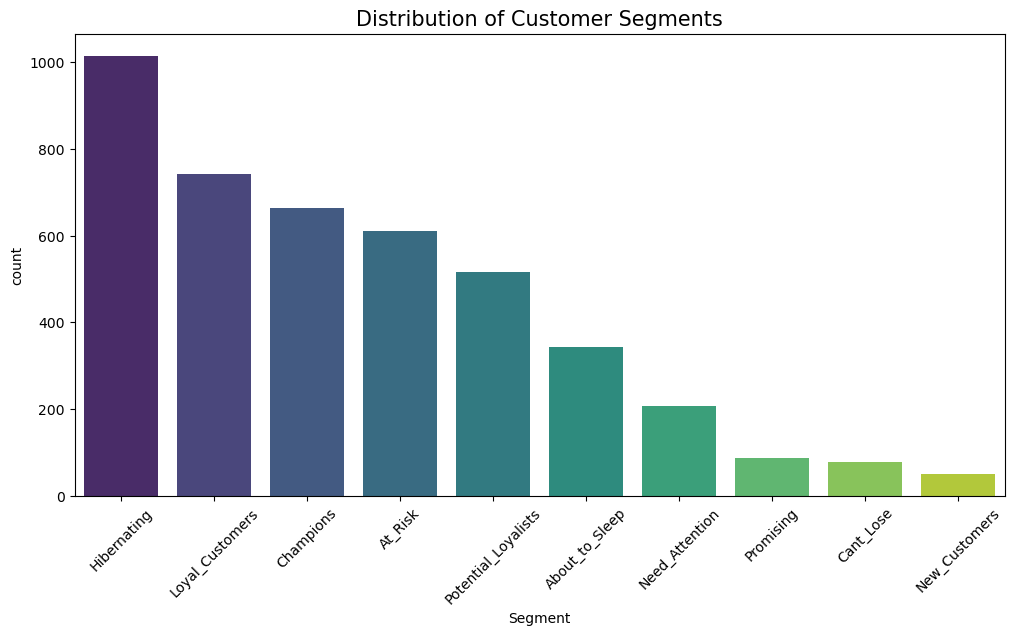

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (12, 6))

# Plot the count of each segment
sns.countplot(x = 'Segment', data = rfm, order = rfm['Segment'].value_counts().index, palette = 'viridis')

plt.title('Distribution of Customer Segments', fontsize = 15)
plt.xticks(rotation = 45) # Rotate x-axis labels for better readability
plt.show()

In [23]:
# Average Values and Counts per Segment
segment_analysis = rfm.groupby('Segment').agg({
    'Recency': ['mean', 'min', 'max'],
    'Frequency': ['mean', 'min', 'max'],
    'Monetary': ['mean', 'min', 'max', 'count'] # Added count aggregation
})

# Display the segment analysis
segment_analysis.head(10)

Recency           Frequency              Monetary  \
                           mean min  max       mean min  max         mean   
Segment                                                                     
About_to_Sleep        54.819242  38   72   1.201166   1    2   441.320000   
At_Risk              153.155483  73  373   3.073650   2    6  1188.878316   
Cant_Lose            125.116883  73  299   9.116883   6   46  4099.450000   
Champions              8.119155   2   16  12.553544   3  205  6852.264167   
Hibernating          214.884729  73  375   1.126108   1    2   403.977836   
Loyal_Customers       37.287062  17   72   6.830189   3   42  2746.067353   
Need_Attention        54.265700  38   72   2.449275   2    3  1060.357005   
New_Customers          9.580000   2   16   1.000000   1    1   386.199200   
Potential_Loyalists   19.793037   2   37   2.017408   1    3   729.510986   
Promising             26.747126  17   37   1.000000   1    1   367.086782   

                                              
                        min        max count  
Segment                                       
About_to_Sleep        24.40    3502.48   343  
At_Risk               24.05   34095.26   611  
Cant_Lose            181.35   26286.75    77  
Champions             75.76  349164.35   663  
Hibernating            2.95   11880.84  1015  
Loyal_Customers       97.40   50291.38   742  
Need_Attention       101.10   13544.99   207  
New_Customers         35.40    2945.38    50  
Potential_Loyalists   10.95   12079.99   517  
Promising             30.30    2389.62    87

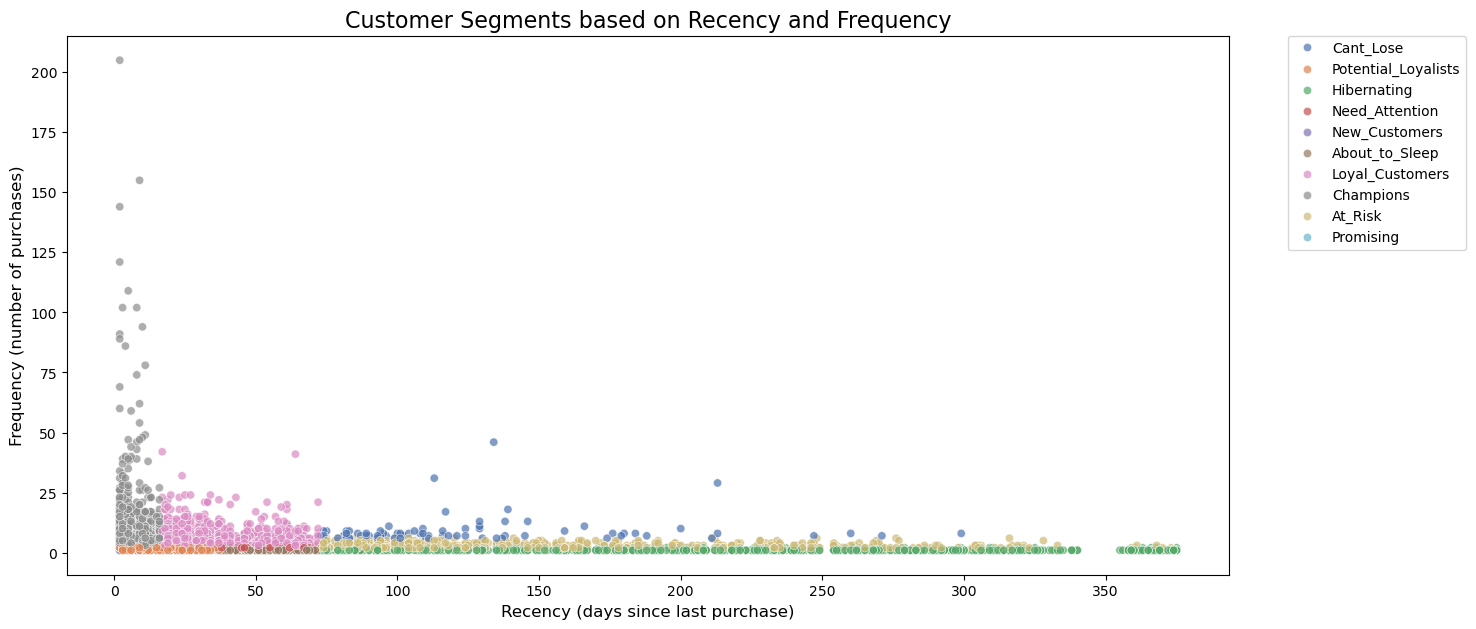

In [24]:
import plotly.express as px 

plt.figure(figsize = (15, 7))
sns.scatterplot(
    data = rfm,
    x = 'Recency',
    y = 'Frequency',
    hue = 'Segment',
    palette = 'deep',
    alpha = 0.7
)

plt.title('Customer Segments based on Recency and Frequency', fontsize = 16)
plt.xlabel('Recency (days since last purchase)', fontsize = 12)
plt.ylabel('Frequency (number of purchases)', fontsize = 12)
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.) # Place legend outside the plot
plt.show()

In [25]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. Log Transformation
rfm_log = np.log1p(rfm[['Recency', 'Frequency', 'Monetary']])

# 2. Standardization
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# Convert back to DataFrame for easier handling
rfm_scaled_df = pd.DataFrame(
    rfm_scaled,
    columns = ['Recency', 'Frequency', 'Monetary']
)
rfm_scaled_df.head()

,Recency,Frequency,Monetary
0,0.980538,1.613017,-0.540688
1,-1.853283,-0.394693,0.447651
2,0.344677,-0.981910,-0.943904
3,-0.078609,0.021945,0.996204
4,-1.081527,-0.981910,-0.707671


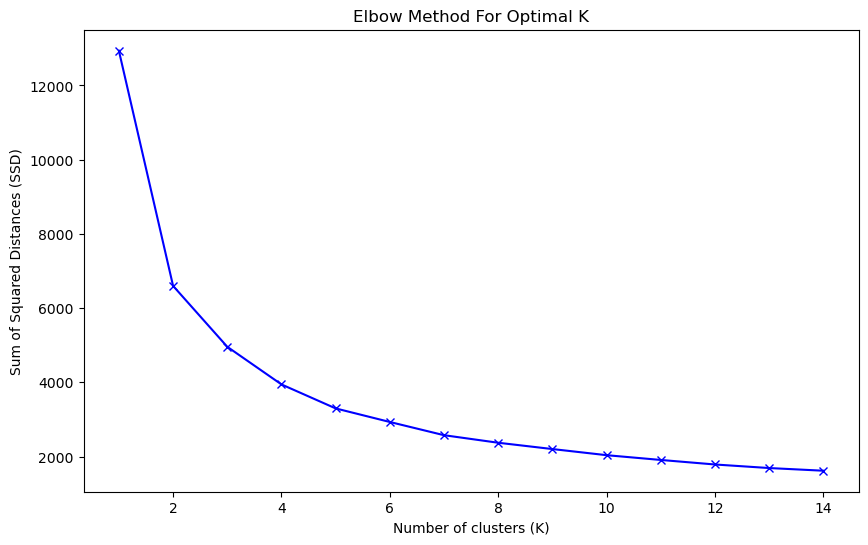

In [26]:
from sklearn.cluster import KMeans

ssd = [] # Sum of Squared Distances
K = range(1, 15) # Trying K values from 1 to 14

for k in K:
    kmeans = KMeans(n_clusters = k, random_state = 1903)
    kmeans.fit(rfm_scaled_df)
    ssd.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize = (10, 6))
plt.plot(K, ssd, 'bx-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Sum of Squared Distances (SSD)')
plt.title('Elbow Method For Optimal K')
plt.show()

In [28]:
# From the elbow graph, let's choose K = 3
kmeans = KMeans(n_clusters = 3, random_state = 1903)
kmeans.fit(rfm_scaled_df)

# Assign cluster labels to each customer
clusters_labels = kmeans.labels_

# Add cluster labels to the original rfm dataframe
rfm_k3 = rfm.assign(Cluster_Id = clusters_labels)

# How many customers in each cluster
rfm_k3['Cluster_Id'].value_counts()

Cluster_Id
2    1779
0    1696
1     837
Name: count, dtype: int64

In [29]:
# Lets see the average values per cluster
cluster_summary = rfm_k3.groupby('Cluster_Id').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(2)

cluster_summary

Recency Frequency Monetary      
              mean      mean     mean count
Cluster_Id                                 
0           167.88      1.31   327.69  1696
1            19.73     13.23  7238.10   837
2            54.08      3.33  1246.74  1779

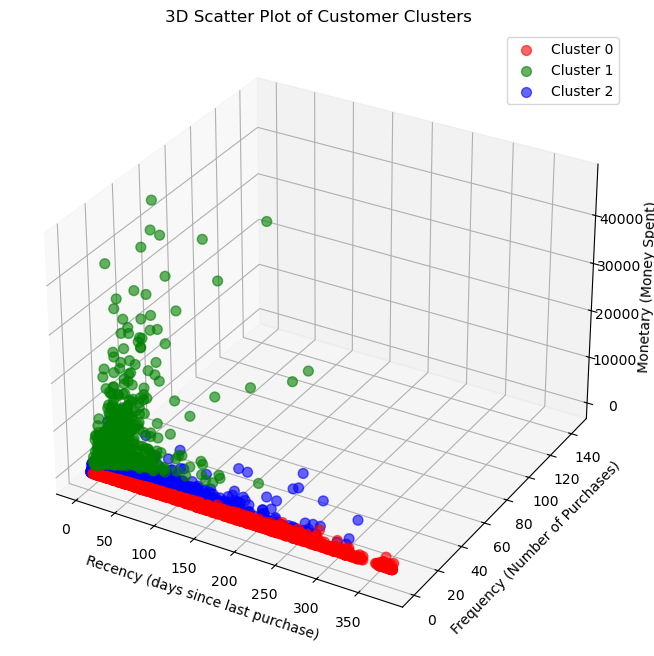

In [31]:
import matplotlib.pyplot as plt

# 3D Scatter Plot of Clusters
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection = '3d')

# Let's separate the clusters for better visualization
colors = ['red', 'green', 'blue'] # 0: red, 1: green, 2: blue

for i in range(3):
    subset = rfm_k3[rfm_k3['Cluster_Id'] == i]
    subset = subset[subset['Monetary'] < 50000]
    ax.scatter(
        subset['Recency'],
        subset['Frequency'],
        subset['Monetary'],
        c = colors[i],
        label = f'Cluster {i}', s = 50, alpha = 0.6
    )

ax.set_xlabel('Recency (days since last purchase)')
ax.set_ylabel('Frequency (Number of Purchases)')
ax.set_zlabel('Monetary (Money Spent)')
ax.set_title('3D Scatter Plot of Customer Clusters')
ax.legend()
plt.show()